### Lab: Q-Learning to Solve the Cliff Walk Problem

### University of Virginia
### Reinforcement Learning
#### Last updated: December 11, 2023

---

#### Instructions:

In Sutton & Barto (Section 6.5), the Cliff Walking problem is presented. You will apply Q-learning to teach an agent to solve it.  

Consider the grid below, where an agent begins in starting state S and wishes to reach goal state G by walking on a path and keeping off The Cliff (the gray region).  At each time step, the agent can potentially take one step left, right, up, or down. There is no discounting.  It is not possible for the agent to move off the grid. If the agent visits The Cliff, it incurs reward -100 and is immediately sent back to the start. The reward is -1 on all transitions apart from The Cliff. This incentivizes the agent to reach G as quickly as possible.

**Note**: Do not use libraries from `networkx`, `gym`, `gymnasium` when solving this problem.

---

<img src="https://github.com/tylergorecki/reinforcement_learning/blob/main/04_q_learning/cliff_walk.png?raw=1">  

#### TOTAL POINTS: 12

---

#### 1) Clearly explain how you will set up the state space and action space.
**(POINTS: 2)**

The state space is each individual cell in the 4x12 grid above and the action space is movement left, right, up or down. This would result in a 4x12x4 3D matrix of possible movements at each state. When exploring which direction to move, I will make sure that no steps are able to go outside of the bounded state space (thus resampling if a sample does result in an outside move). For reference, the bottom left starting cell is [3,0] and the bottom right goal state is [3,11].

#### 2) Write a Q-learning algorithm that helps the agent learn a policy to reach the goal  
**(POINTS: 8)**.

Use $\epsilon$-greedy action selection with $\epsilon=0.1$.  
You can decide the other parameters as you wish.  

In [166]:
import numpy as np
import matplotlib.pyplot as plt

Helper functions

In [167]:
def possible_actions(state):
  # based on state location, return list of possible directions to move
  possible_actions = []
  if state[0] < 3: # if not on bottom row, can move down
    possible_actions.append(0)
  if state[0] > 0: # if not on top row, can move up
    possible_actions.append(2)
  if state[1] < 11: # if not on right edge, can move right
    possible_actions.append(1)
  if state[1] > 0: # if not on left edge, can move left
    possible_actions.append(3)
  return possible_actions

def egreedy(q_vals, state, policy, epsilon = 0.1):
  actions = possible_actions(state)
  # print(state, actions)
  if policy is None: # if there is no known policy
    if np.random.random() < epsilon:
      # randomly selection from any of the possible movements
      return np.random.choice(actions)
    else:
      # select the highest value from any of the possible movements
      # print(q_vals[state[0], state[1], actions])
      return actions[np.argmax(q_vals[state[0], state[1], actions])]
  else: # if we have a known policy, want to use it every time
    return actions[np.argmax(q_vals[state[0], state[1], actions])]

def step(state, action):
  # possible movement in all directions
  if action == 0: # down
    next_state = [state[0]+1, state[1]]
  elif action == 1: # right
    next_state = [state[0], state[1]+1]
  elif action == 2: # up
    next_state = [state[0]-1, state[1]]
  elif action == 3: # left
    next_state = [state[0], state[1]-1]

  reward = -1
  done = False

  if next_state[0] == 3:
    if next_state[1] == 11:
      reward = 0 # reward 0 in goal state
      done = True # if goal reached, end run
    elif next_state[1] == 0:
      reward = -1 # re-setting reward it to -1 if reaches start again
      done = False # keep run going if start reached again
    else:
      reward = -100 # reward -100 in cliff area
      done = True # if cliff reached, end run

  return next_state, reward, done

Q-learning function

In [168]:
def q_learning(episodes = 500, exploration = 0.1, verbose = False, policy = None):
  if policy is None: # with no previous policy knowledge, set q values to 0
    q_vals = np.zeros((4,12,4))
  else: # if we have policy, set q values to that policy
    q_vals = policy

  rewards = []
  final_states = []

  for i in range(episodes):
    if verbose: print('Iteration:', i+1, '\n')
    state = [3,0]
    episode_reward = 0
    done = False
    stepcount = 1
    while not done:
      # determine action
      if verbose: print('State:', state)
      action = egreedy(q_vals, state, policy, exploration)
      ## if verbose: print('Action:', action)
      # take action
      next_state, reward, done = step(state, action)
      ## if verbose: print('Next state:', next_state, '\nReward:', reward, '\nDone:', done)
      episode_reward += reward
      # update q_vals
      if done:
        q_vals[state[0], state[1], action] = reward
      else:
        max_action = np.max(q_vals[next_state[0], next_state[1], possible_actions(next_state)])
        q_vals[state[0], state[1], action] = reward + max_action
      # update state
      state = next_state
      # update step count
      ## if verbose: print(f'Step {stepcount} complete \n')
      stepcount += 1

    stepcount = 1
    if verbose:
      #if i == 0 or i % 100 == 99:
      print('Final state:', state)
      print(f'\nEpisode {i+1} reward:', episode_reward, '\n')

    final_states.append(state)
    rewards.append(episode_reward)

  return final_states, rewards, q_vals

**Note to grader for partial credit:**  
Student answers in parts 3-5 should help understand if the algorithm is implemented correctly.  


#### 3) After training the policy, print the row from the Q-table representing the starting state  

In [169]:
final_states, rewards, q_vals = q_learning(episodes = 500, exploration = 0.1)
q_vals[3,0]

array([   0., -100.,  -12.,    0.])

This makes sense as the agent is not able to move down or left so those actions are still zeros like the default values. Moving right would go right into the cliff area, so that value is -100, and going up is -12 as the agent is 12 steps away from the goal state (with an ideal path).

#### 4) Based on training results, create a plot that shows final state of each episode on the y-axis, and the episode number on the x-axis

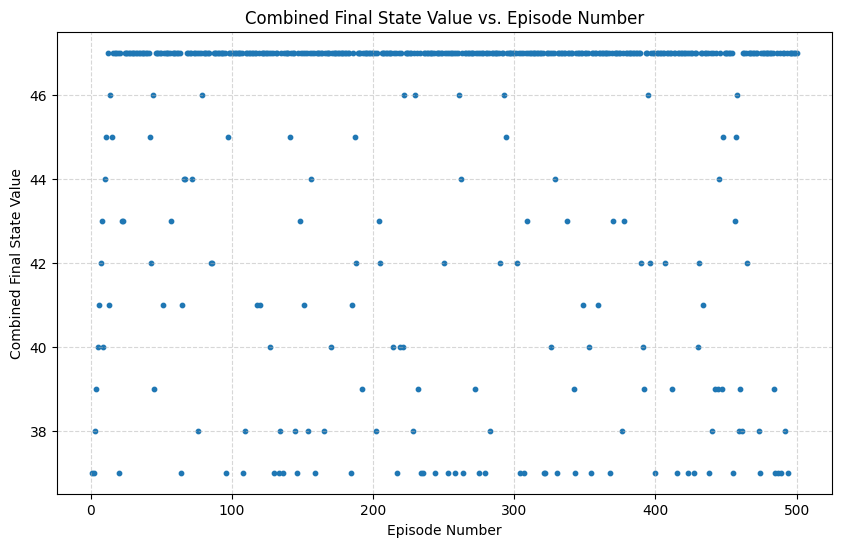

In [170]:
# Need to convert final [x,y] states into single values, row*12 + col, 0-47
final_states_adj = [state[0] * 12 + state[1] for state in final_states]

plt.figure(figsize=(10, 6))

plt.scatter(range(1, 501), final_states_adj, s=10)

plt.xlabel("Episode Number")
plt.ylabel("Combined Final State Value")
plt.title("Combined Final State Value vs. Episode Number")

plt.grid(True, linestyle="--", alpha=0.5)

plt.show()

The outcomes from this plot show that the end state (value 3*12+11 = 47) is reached a majority of the time. The range also has a lower bound of 37 because the furthest left cliff state has the smallest value of all terminal states. While some mistakes are made throughout, after the first 10 or so iterations, the agent figures out how to reach the end state by avoiding the cliff.

#### 5) Given the learned policy, run one episode

Show evidence that the agent has learned how to successfully complete the Cliff walk

In [171]:
final_states, rewards, q_vals = q_learning(episodes = 1, exploration = 0.1, verbose=True, policy = q_vals)

Iteration: 1 

State: [3, 0]
State: [2, 0]
State: [2, 1]
State: [2, 2]
State: [2, 3]
State: [2, 4]
State: [2, 5]
State: [2, 6]
State: [2, 7]
State: [2, 8]
State: [2, 9]
State: [2, 10]
State: [2, 11]
Final state: [3, 11]

Episode 1 reward: -12 



#### 6) Explain your results. Do they make sense?
**(POINTS: 2)**

Yes, these results make sense as the agent is able to go from the initial state to the goal state in only 12 steps (the minimum based on the distance and cliff obstacle) when following the learned q-values policy. The agent initially moves up, then all the way to the right of the state space, then down to the goal state, which is shown in the output above. The final reward is -12 as that is the largest which can be achieved when -1 is awarded during each step iteration. This was an interesting simple application of q-learning and it was cool to see convergence relatively quickly.

**Note to grader for partial credit:** Grade based on the reasoning.